In [22]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import random
from sklearn.neighbors import KernelDensity

import gdown

In [23]:
# Setting seed for reproducibility of results
def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Set global random seed
set_seed(42)

## E-commerce Customer Data For Behavior Analysis

In [24]:
# Load and preview dataset
# You can download the csv from this link 
# https://www.kaggle.com/datasets/shriyashjagtap/e-commerce-customer-for-behavior-analysis?select=ecommerce_customer_data_large.csv

df = pd.read_csv("ecommerce_customer_data_large.csv")
df.head()

,Customer ID,Purchase Date,Product Category,Product Price,Quantity,Total Purchase Amount,Payment Method,Customer Age,Returns,Customer Name,Age,Gender,Churn
0,44605,2023-05-03 21:30:02,Home,177,1,2427,PayPal,31,1.0,John Rivera,31,Female,0
1,44605,2021-05-16 13:57:44,Electronics,174,3,2448,PayPal,31,1.0,John Rivera,31,Female,0
2,44605,2020-07-13 06:16:57,Books,413,1,2345,Credit Card,31,1.0,John Rivera,31,Female,0
3,44605,2023-01-17 13:14:36,Electronics,396,3,937,Cash,31,0.0,John Rivera,31,Female,0
4,44605,2021-05-01 11:29:27,Books,259,4,2598,PayPal,31,1.0,John Rivera,31,Female,0


### Data Preprocessing

In [25]:
df['Purchase Date'] = pd.to_datetime(df['Purchase Date'], format='%Y-%m-%d %H:%M:%S')
df.drop(columns=['Customer Age', 'Customer Name'], inplace=True)
df.dropna(axis=0, inplace=True)
# Convert 'Returns' column to integer
df['Returns'] = df['Returns'].astype(int)

"""Remove unwanted category that we are not using in our ecommerce company"""
df =  df[df['Product Category'] != 'Books']

df = df[['Age', 'Gender', 'Payment Method']]

### Synthetic Data Generation

In [26]:
n_samples = 100001

# Step 1: Group by the categorical columns
grouped = df.groupby(['Gender', 'Payment Method'])

# Step 2: Stratify sampling from the categorical variables
# Sample proportionally from each group
categorical_sampled = grouped.apply(lambda x: x.sample(frac=n_samples/len(df), random_state=42)).reset_index(drop=True)


# Function to resample age based on KDE fit to original data
def resample_age(original_group, sampled_group, n_samples, random_state=42):
    # Fit KDE to the Age column in the original group
    kde = KernelDensity(kernel='gaussian', bandwidth=1.0)  # You can adjust the bandwidth
    kde.fit(original_group[['Age']])
    
    # Set the random seed
    np.random.seed(random_state)
    
    # Sample new ages from the KDE
    new_ages = kde.sample(n_samples, random_state=random_state)
    
    # Update the Age column in the sampled group
    sampled_group['Age'] = new_ages
    return sampled_group

# Group by the categorical columns in the original data
grouped_original = df.groupby(['Gender', 'Payment Method'])

# For each group in the sampled data, resample the Age
categorical_sampled = categorical_sampled.groupby(['Gender', 'Payment Method']).apply(
    lambda x: resample_age(grouped_original.get_group((x.name)), x, len(x))
).reset_index(drop=True)

categorical_sampled['Age'] = categorical_sampled['Age'].astype(int)

# Rename the index to 'CustomerID'
categorical_sampled.index.name = 'CustomerID'
categorical_sampled = categorical_sampled.iloc[:-1]
#categorical_sampled.info()

C:\Users\CelesteN\AppData\Local\Temp\ipykernel_30568\485541707.py:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  categorical_sampled = grouped.apply(lambda x: x.sample(frac=n_samples/len(df), random_state=42)).reset_index(drop=True)
C:\Users\CelesteN\AppData\Local\Temp\ipykernel_30568\485541707.py:31: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  categorical_sampled = categorical_sampled.groupby(['Gender'

# Dataset for E-Customer Customer Churn & Behaviour Analysis

In [27]:
# Load and preview dataset
# https://github.com/Leangonplu/Ecommerce_Customer_Churn_Analysis_and_Prediction

data = pd.read_excel("churn.xlsx")
data.head()

,CustomerID,Churn,Tenure,PreferredLoginDevice,CityTier,WarehouseToHome,PreferredPaymentMode,Gender,HourSpendOnApp,NumberOfDeviceRegistered,PreferedOrderCat,SatisfactionScore,MaritalStatus,NumberOfAddress,Complain,OrderAmountHikeFromlastYear,CouponUsed,OrderCount,DaySinceLastOrder,CashbackAmount
0,50001,1,4.0,Mobile Phone,3,6.0,Debit Card,Female,3.0,3,Laptop & Accessory,2,Single,9,1,11.0,1.0,1.0,5.0,159.93
1,50002,1,NaN,Phone,1,8.0,UPI,Male,3.0,4,Mobile,3,Single,7,1,15.0,0.0,1.0,0.0,120.90
2,50003,1,NaN,Phone,1,30.0,Debit Card,Male,2.0,4,Mobile,3,Single,6,1,14.0,0.0,1.0,3.0,120.28
3,50004,1,0.0,Phone,3,15.0,Debit Card,Male,2.0,4,Laptop & Accessory,5,Single,8,0,23.0,0.0,1.0,3.0,134.07
4,50005,1,0.0,Phone,1,12.0,CC,Male,NaN,3,Mobile,5,Single,3,0,11.0,1.0,1.0,3.0,129.60


We selected the columns we believe would offer the most valuable insights into customer behavior, with information like Tenure, Satisfication Score and Coupon Used being some of the columns kept.

In [28]:
# Select columns
cols = ['CustomerID','Churn', 'Tenure', 'HourSpendOnApp', 'NumberOfDeviceRegistered', 'SatisfactionScore', 'CouponUsed', 'CashbackAmount']
df = data[cols]

df.drop_duplicates(inplace=True)

df.head()

,CustomerID,Churn,Tenure,HourSpendOnApp,NumberOfDeviceRegistered,SatisfactionScore,CouponUsed,CashbackAmount
0,50001,1,4.0,3.0,3,2,1.0,159.93
1,50002,1,NaN,3.0,4,3,0.0,120.90
2,50003,1,NaN,2.0,4,3,0.0,120.28
3,50004,1,0.0,2.0,4,5,0.0,134.07
4,50005,1,0.0,NaN,3,5,1.0,129.60


## Summary Statistics

In [29]:
df.describe()

,CustomerID,Churn,Tenure,HourSpendOnApp,NumberOfDeviceRegistered,SatisfactionScore,CouponUsed,CashbackAmount
count,5630.000000,5630.000000,5366.000000,5375.000000,5630.000000,5630.000000,5374.000000,5630.000000
mean,52815.500000,0.168384,10.189899,2.931535,3.688988,3.066785,1.751023,177.223030
std,1625.385339,0.374240,8.557241,0.721926,1.023999,1.380194,1.894621,49.207036
min,50001.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000
25%,51408.250000,0.000000,2.000000,2.000000,3.000000,2.000000,1.000000,145.770000
50%,52815.500000,0.000000,9.000000,3.000000,4.000000,3.000000,1.000000,163.280000
75%,54222.750000,0.000000,16.000000,3.000000,4.000000,4.000000,2.000000,196.392500
max,55630.000000,1.000000,61.000000,5.000000,6.000000,5.000000,16.000000,324.990000


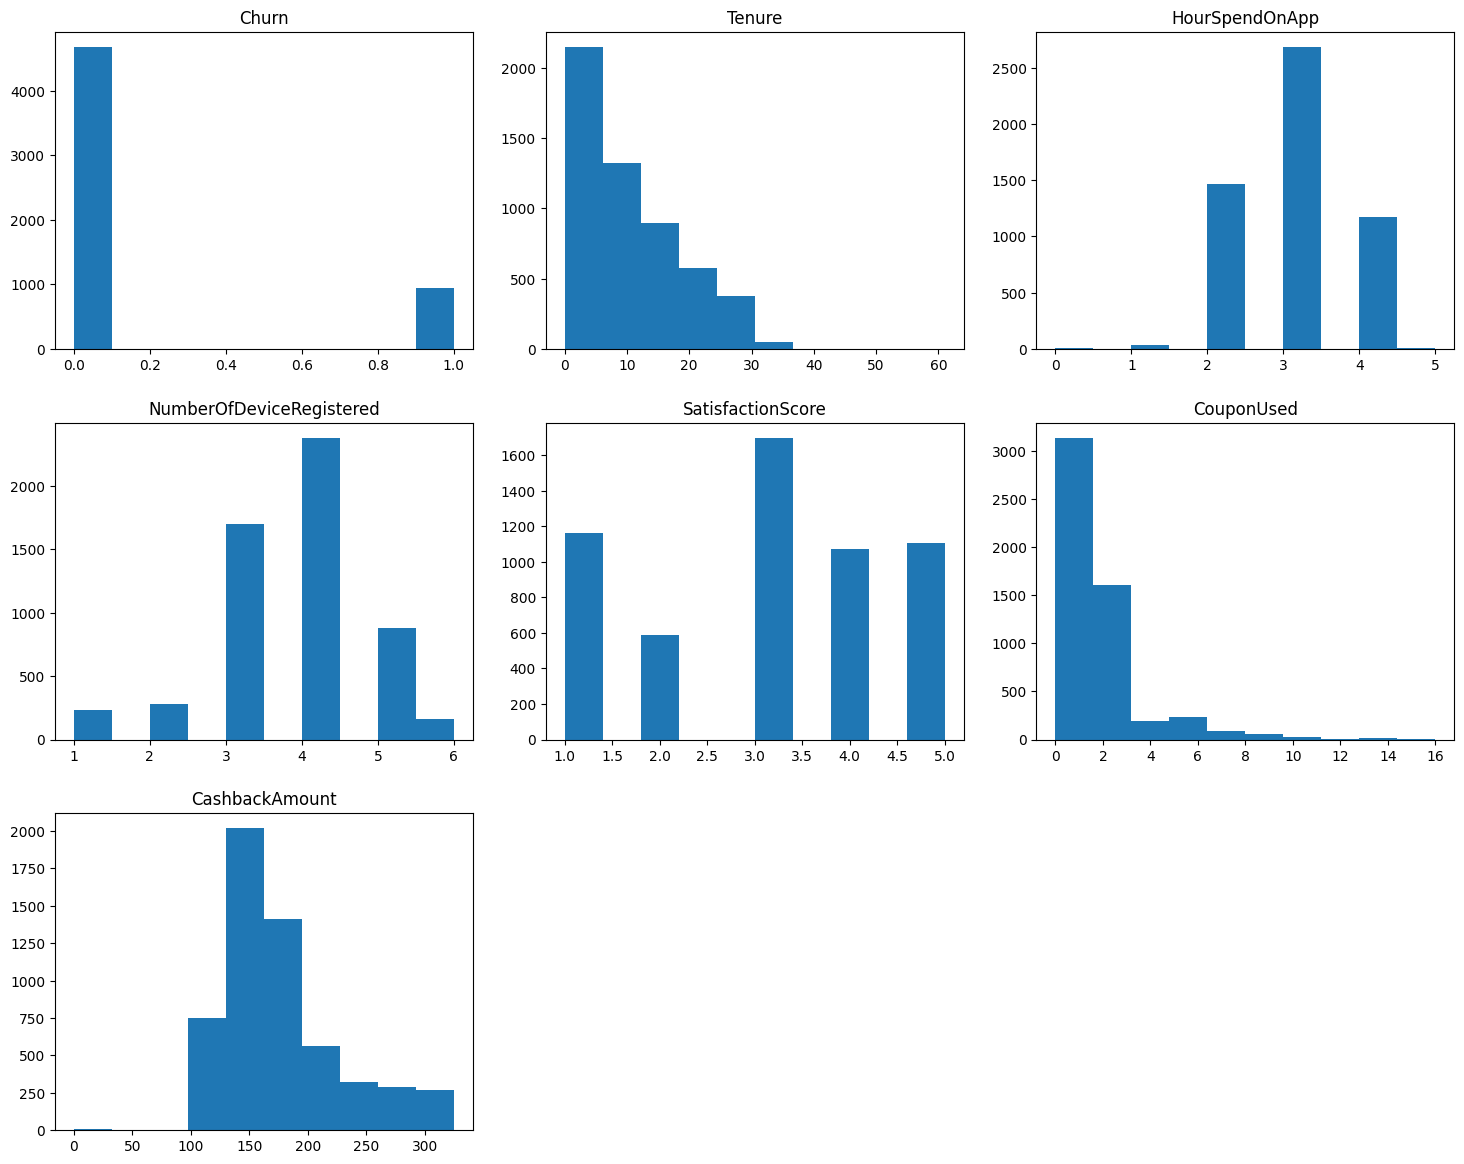

In [30]:
# Plot the distribution of columns

plt.figure(figsize=(15,12))

i = 1
for col in df.drop(['CustomerID'], axis = 1).columns:
    plt.subplot(3,3, i)
    plt.hist(df[col])
    plt.title(col)
    i += 1

plt.tight_layout(pad=2.0)
plt.show()

## Dealing with missing values

In [31]:
# Check for columns with missing values
df.isna().sum()

CustomerID                    0
Churn                         0
Tenure                      264
HourSpendOnApp              255
NumberOfDeviceRegistered      0
SatisfactionScore             0
CouponUsed                  256
CashbackAmount                0
dtype: int64

Based on the distribution of these columns with missing values (mainly being skewed) and considering that the missing values are most likely due to information not being collected (e.g., new customers/ no such statistics), we decided to replace these missing values with 0 to maintain data consistency and ensure meaningful analysis.

In [32]:
df.fillna(0, inplace=True)

We also decided to change the dtype of CouponUsed to ensure that values from these columns can strictly only be integers

In [33]:
df.dtypes

CustomerID                    int64
Churn                         int64
Tenure                      float64
HourSpendOnApp              float64
NumberOfDeviceRegistered      int64
SatisfactionScore             int64
CouponUsed                  float64
CashbackAmount              float64
dtype: object

In [34]:
df.loc[:,'CouponUsed'] = df['CouponUsed'].astype(np.int64)

In [35]:
df.head()

,CustomerID,Churn,Tenure,HourSpendOnApp,NumberOfDeviceRegistered,SatisfactionScore,CouponUsed,CashbackAmount
0,50001,1,4.0,3.0,3,2,1.0,159.93
1,50002,1,0.0,3.0,4,3,0.0,120.90
2,50003,1,0.0,2.0,4,3,0.0,120.28
3,50004,1,0.0,2.0,4,5,0.0,134.07
4,50005,1,0.0,0.0,3,5,1.0,129.60


## Synthetic Data Generation

We believe that the relationships in this Customer dataset might be complex, and might be of various distributions. Hence, CTGAN from SDV package was chosen as the technique for generating synthetic data.

In [36]:
from sdv.single_table import CTGANSynthesizer
from sdv.metadata import SingleTableMetadata

# Drop CustomerID since new customers data will be generated
df.drop(['CustomerID'], axis = 1, inplace=True)

metadata = SingleTableMetadata()

metadata.detect_from_dataframe(df)

synthesizer = CTGANSynthesizer(metadata, verbose=True, )
synthesizer.fit(df)

synthetic_data = synthesizer.sample(num_rows=100000)

synthetic_data['CustomerID'] = synthetic_data.index

synthetic_data.head()

c:\Python312\Lib\site-packages\sdv\single_table\base.py:97: UserWarning: We strongly recommend saving the metadata using 'save_to_json' for replicability in future SDV versions.
  warnings.warn(
Gen. (-0.99) | Discrim. (-0.07): 100%|██████████| 300/300 [07:06<00:00,  1.42s/it]


,Churn,Tenure,HourSpendOnApp,NumberOfDeviceRegistered,SatisfactionScore,CouponUsed,CashbackAmount,CustomerID
0,0,24.0,2.0,1,3,0.0,154.139736,0
1,0,28.0,2.0,4,2,3.0,181.432317,1
2,0,15.0,2.0,3,4,0.0,158.854320,2
3,1,1.0,0.0,3,4,0.0,123.408087,3
4,1,0.0,2.0,6,3,0.0,118.313073,4


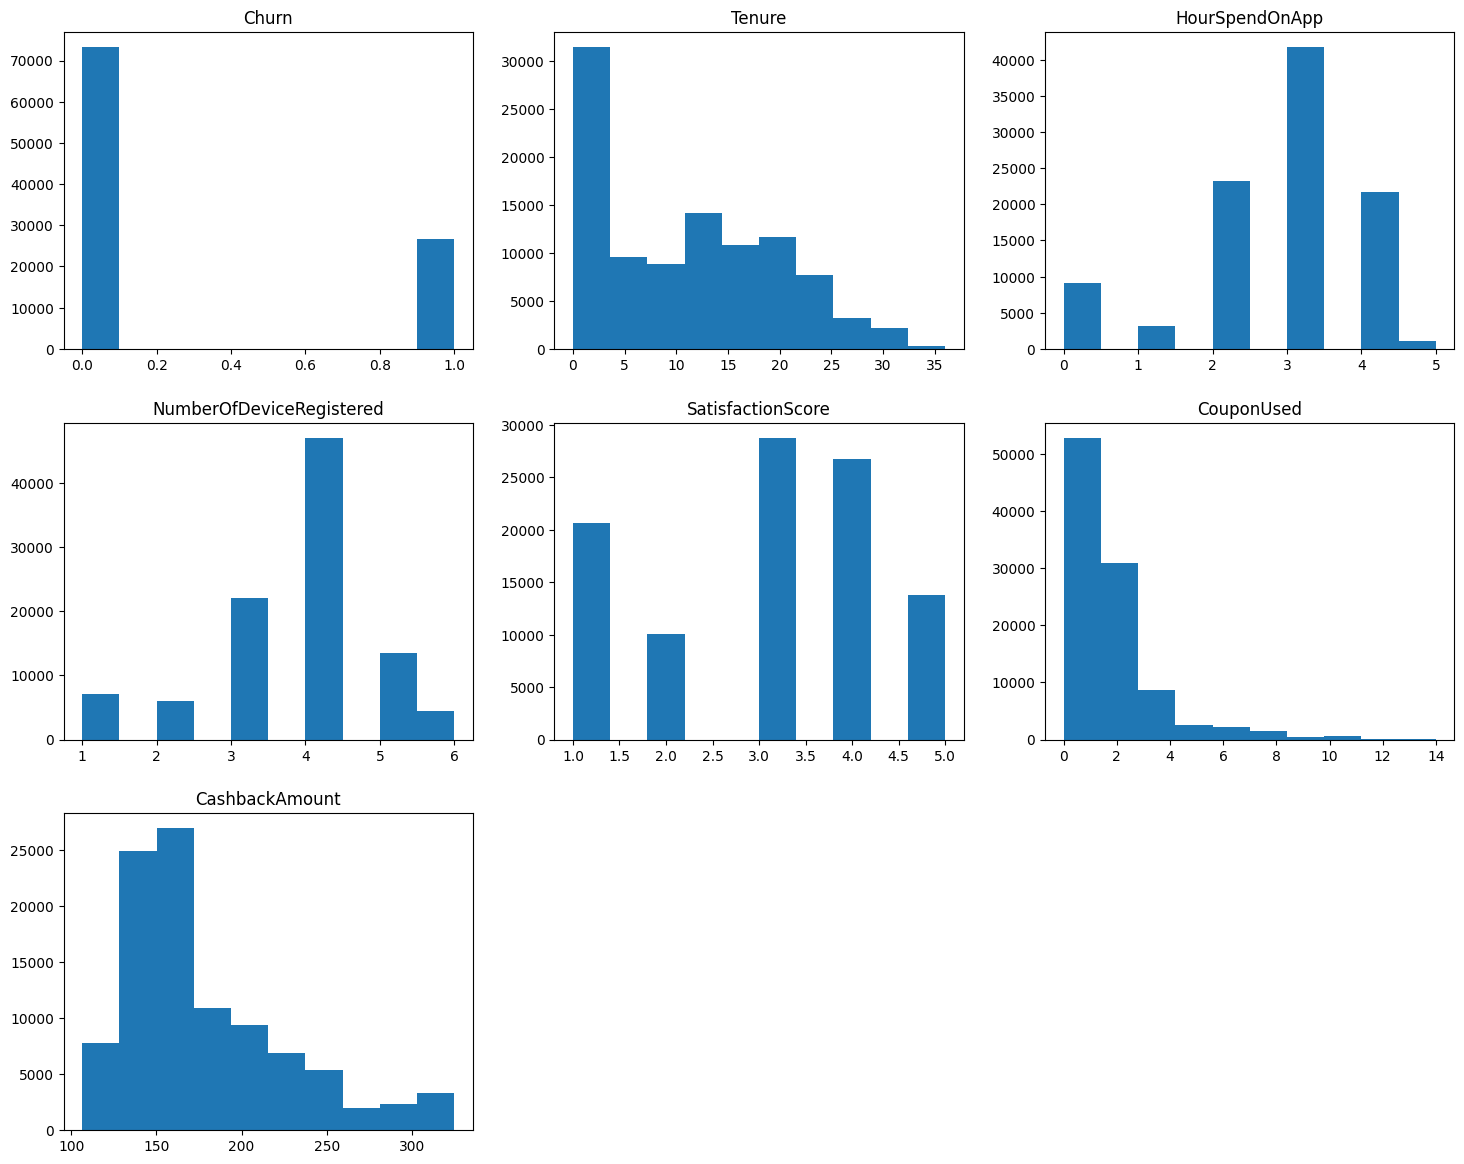

In [37]:
# Plot the distribution of values of synthetic data to ensure that distribution is roughly similar to original dataset

plt.figure(figsize=(15,12))

i = 1
for col in synthetic_data.drop(['CustomerID'], axis = 1, inplace = False).columns:    
    plt.subplot(3,3, i)
    plt.hist(synthetic_data[col])
    plt.title(col)
    i += 1

plt.tight_layout(pad=2.0)
plt.show()        

## Merging & exporting final Customer Dataset

In [38]:
# Merge the two datasets to generate final Customers Dataset
customers = categorical_sampled.merge(right = synthetic_data, on='CustomerID')

# Ensure that there is 100000 customer information with the right columns
customers.tail()

,CustomerID,Age,Gender,Payment Method,Churn,Tenure,HourSpendOnApp,NumberOfDeviceRegistered,SatisfactionScore,CouponUsed,CashbackAmount
99995,99995,31,Male,PayPal,1,23.0,4.0,4,3,2.0,146.262519
99996,99996,21,Male,PayPal,1,1.0,3.0,4,3,1.0,167.079085
99997,99997,56,Male,PayPal,0,15.0,3.0,4,5,1.0,220.653623
99998,99998,37,Male,PayPal,1,1.0,0.0,3,4,1.0,126.393686
99999,99999,40,Male,PayPal,0,4.0,3.0,2,3,0.0,150.917019


In [39]:
# Export final dataset
customers.to_csv('Customers.csv')